In [42]:
# Import packages
library(tidyverse)
library(bnlearn)

# File paths

In [43]:
met_source = 'era5' # choose from 'metno', 'era5' or 'nomet' (the last for a BN with no met nodes)

# End year of desired training data (check BayesianNetwork/Data/BN_TrainingData folder for available date ranges)
# Or set to all the same year if you want to compare like with like
end_yr_li = list('metno'=2018,
                 'era5'=2018,
                 'nomet'=2020)

# File path to training data matrix (includes all available data, no NaN patching. Therefore maybe slightly different results to CV)
training_data_fpath = sprintf("../Data/BN_TrainingData/TrainingData_GaussianBN_%s_1981-%s.csv", met_source, end_yr_li[[met_source]])

# File path to save bn.fit object to (to be used in making predictions)
rfile_fpath = sprintf("../Data/RData/Vansjo_fitted_GaussianBN_%s_1981-%s.rds", met_source, end_yr_li[[met_source]])

# Output from fitted network
out_folder = "../Data/FittedNetworkDiagnostics"

# Create a fitted bayesian network

Save fitted network to file for use elsewhere

In [44]:
# Create the network structure manually

if(met_source == 'nomet')
    {# Create an empty DAG with the desired nodes, in this case no met ones
    nodes = c('TP',
              'TP_prevSummer',
              'chla',
              'chla_prevSummer',
              'cyano', # N.B. boxcox transformed training data
              'colour_prevSummer',
              'colour'
                 )
    dag = empty.graph(nodes)

    # Manually define the arcs connecting nodes
    arcs_matrix = matrix(c('TP_prevSummer','TP',
                           'TP','chla',
                           'chla_prevSummer','chla',
                           'chla','cyano',
                           'colour','cyano',
                           'colour_prevSummer','colour'
                             ),
                            ncol = 2, byrow = TRUE,
                            dimnames = list(NULL, c("from", "to")))
    
    } else {# Create an empty DAG with the desired nodes, in this case including met ones
    nodes = c('TP',
              'TP_prevSummer',
              'chla',
              'chla_prevSummer',
              'wind_speed',
              'cyano', # N.B. boxcox transformed training data
              'colour_prevSummer',
              'colour',
              'rain'
                 )

    dag = empty.graph(nodes)

    # Manually define the arcs connecting nodes
    arcs_matrix = matrix(c('TP_prevSummer','TP',
                           'TP','chla',
                           'chla_prevSummer','chla',
                           'wind_speed','chla',
                           'chla','cyano',
                           'colour','cyano',
                           'colour_prevSummer','colour',
                           'rain','colour'
                             ),
                            ncol = 2, byrow = TRUE,
                            dimnames = list(NULL, c("from", "to")))
    }
                         
# Assign the structure to the empty graph using arcs, which turns it into a bnlearn object
arcs(dag) = arcs_matrix
dag


  Random/Generated Bayesian network

  model:
   [TP_prevSummer][chla_prevSummer][wind_speed][colour_prevSummer][rain]
   [TP|TP_prevSummer][colour|colour_prevSummer:rain]
   [chla|TP:chla_prevSummer:wind_speed][cyano|chla:colour]
  nodes:                                 9 
  arcs:                                  8 
    undirected arcs:                     0 
    directed arcs:                       8 
  average markov blanket size:           2.89 
  average neighbourhood size:            1.78 
  average branching factor:              0.89 

  generation algorithm:                  Empty 


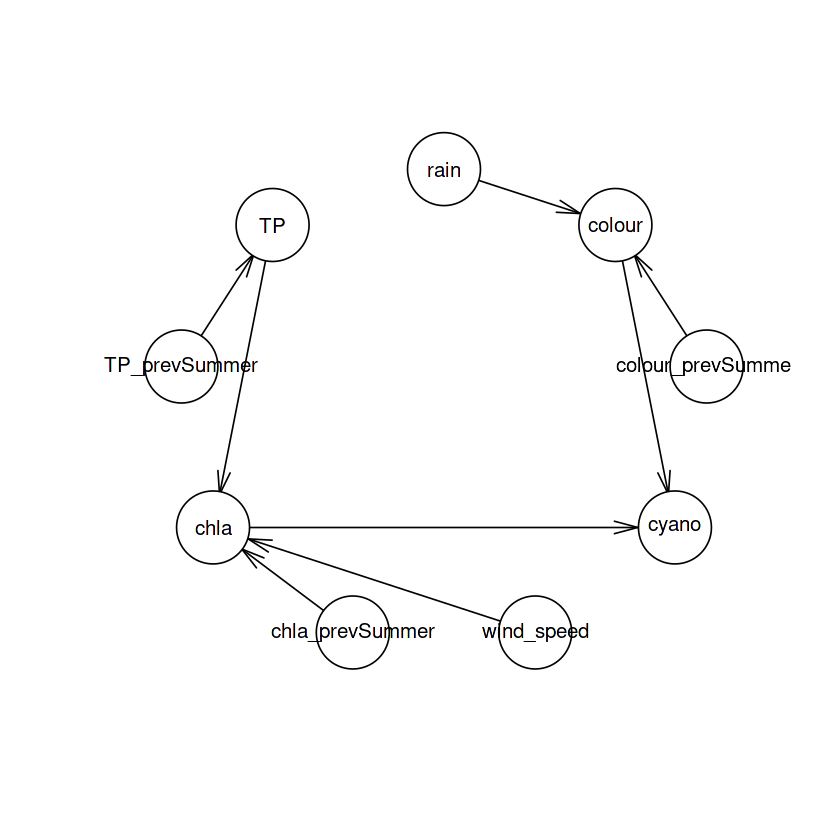

In [45]:
plot(dag)

In [46]:
# Read in historic data which will be used to fit the network params
data_cont = read.csv(file=training_data_fpath, header=TRUE, sep=",", row.names = 1)
data_cont[1:ncol(data_cont)] = lapply(data_cont[1:ncol(data_cont)], as.numeric) # Convert any integer cols to numeric
data_cont = data_cont[ , (names(data_cont) %in% nodes)] # Remove any columns that aren't present in the network nodes

# Quick look
head(data_cont)

,rain,colour,TP,chla,wind_speed,cyano,colour_prevSummer,TP_prevSummer,chla_prevSummer
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1980,546.2346,NA,43.57302,16.08013,2.302666,NA,NA,NA,NA
1981,508.5560,NA,28.83333,8.33125,2.471487,NA,NA,43.57302,16.08013
1982,557.7706,26.66667,26.98810,5.97500,2.673500,NA,NA,28.83333,8.33125
1983,459.4996,17.62500,29.78125,6.05000,2.735913,NA,26.66667,26.98810,5.97500
1984,599.9176,NA,26.52750,11.09000,2.415682,NA,17.62500,29.78125,6.05000
1985,533.9176,34.40476,30.95714,11.89524,2.390617,NA,NA,26.52750,11.09000


In [47]:
# Fit. Returns a bn.fit object, which includes fitted conditional probability tables for each node
fitted_BN = bn.fit(dag, data_cont)

# Quick look at the fitted coefficients associated with each node
coefficients(fitted_BN)

$TP
  (Intercept) TP_prevSummer 
   10.8906157     0.6061798 

$TP_prevSummer
(Intercept) 
   29.51101 

$chla
    (Intercept)              TP chla_prevSummer      wind_speed 
     13.7776123       0.4147943       0.4335452      -6.7976952 

$chla_prevSummer
(Intercept) 
   15.62268 

$wind_speed
(Intercept) 
   2.511071 

$cyano
(Intercept)        chla      colour 
-1.78977349  0.16870336 -0.02436988 

$colour_prevSummer
(Intercept) 
   41.16852 

$colour
      (Intercept) colour_prevSummer              rain 
       -6.0495446         0.8295858         0.0240793 

$rain
(Intercept) 
   510.1953

In [48]:
# Save bn.fit object to file for reading later & using to make predictions
saveRDS(fitted_BN, file = rfile_fpath )

# Save auxiliary info associated with the network

Save coefficients and standard deviations for use elsewhere

In [49]:
# Standard deviation of the residuals

# First, make an empty list and then populate it with the standard deviations
sd_li = vector(mode = "list", length = 0)
for (node in nodes(dag))
    {sd = fitted_BN[[node]]$sd
     sd_li[[node]] = sd
    }

# Then turn into a dataframe & save to csv to accompany predictions
sd_df = data.frame(node = nodes(dag), sd = unlist(sd_li, use.names=FALSE))
out_fpath = file.path(out_folder, sprintf("GBN_%s_1981-%s_stdevs.csv", met_source, end_yr_li[[met_source]]))
write.csv(sd_df,out_fpath, row.names = FALSE)

sd_df

node,sd
<chr>,<dbl>
TP,3.821531
TP_prevSummer,5.156268
chla,3.792426
chla_prevSummer,5.595212
wind_speed,0.140378
cyano,0.735678
colour_prevSummer,17.258226
colour,9.104638
rain,90.633715


In [50]:
# Coefficients are in a named list. Doesn't seem easy to write this to text file with a nice format
# Best I've come up with so far (no label info included):
out_fpath = file.path(out_folder, sprintf("coeffs_%s_1981-%s.csv",met_source, end_yr_li[[met_source]]))
lapply(coefficients(fitted_BN), write, out_fpath, append=TRUE, ncolumns=10);

$TP
NULL

$TP_prevSummer
NULL

$chla
NULL

$chla_prevSummer
NULL

$wind_speed
NULL

$cyano
NULL

$colour_prevSummer
NULL

$colour
NULL

$rain
NULL